# Traffic Sign Recognition using Histogram of Oriented Gradient and Convolutional Neural Network
This notebook will showcase the training process of the traffic sign recognizer using neural network. Before you click Run All, it is important to check that the following packages were installed on your host machine.
  1. opencv-python
  2. tensorflow
  3. numpy
  4. scikit-image
  5. scipy

## Move your dataset to the src folder
Note that you should rename the files of a type as "XXXX_" where XXXX is the label of the image,
the label should not be more than 4 characters!


## Data Acqusition 
Loading the dataset along with the respective labels
If the dataset has one __80 speed limit__ sign and another __stop__ sign,
the labels will be ['80', 'Stop']
__Note__: The size of data and label should be the same, report to us if you find the size was different.

In [1]:
import common as cm

cm.files_rename('src')
data, labels = cm.load_data('src')
print('Size of Data:', len(data))
print('Size of Label:', len(labels))

Size of Data: 4651
Size of Label: 4651


## Preprocessing Stage
Every image in the dataset will undergo the preprocessing stage which included the following operations:
  1. Histogram Normalization - to enhance the constrast and detail of an image
  2. Hough Transform - to detect the largest circle in the image and return the content within the circle, it was set to accept not so round shape as well.
  3. HOG feature descriptor - to extract the feature from the images, features as in the change in gradient.
  4. Reshaping - reshape the image to (*image.shape, 1) for the classifier
You may notice the data size was reduced to a lower number.
This is because the preprocessor will filter out those photos in awful quality, or when the Hough transform failed to detect round shape on the image.

In [2]:
import numpy as np
from parallel import preprocess_image_parallel as preprocess

dataset, label = preprocess(data, labels) # dataset
data_size = len(dataset)
data_type = type(dataset)
print(f'''
Data size: {data_size}
Data type: {data_type}
''')

Data size: 4651 and data chunk per core: 465

Data size: 4500
Data type: <class 'numpy.ndarray'>



The following code shows the sizes of each type of traffic signs.
Depending on the traffic signs dataset you downloaded, the sizes of each type of traffic signs can be different.
The counting was presented as the following format:
(name_of_sign, size_of_sign)

In [3]:
import collections

counter = collections.Counter(label)
counter.most_common()

[('80', 1259), ('TC', 989), ('GS', 721), ('NE', 703), ('SP', 528), ('TK', 300)]

## Preprocessing Stage 2
It is required to convert the image dataset to numpy array for the classifier to work with.
For the label, we first converted them into numeric form ('80' -> 0, 'SP' -> 1, etc.)
Then, the label was categorized into the CNN preferred format which is:
say there is 5 types of sign, and the first sign is __80 speed limit sign__ which is the index 0 after the conversion will become
  [1, 0, 0, 0, 0]
where the remaining 4 zeros are reserved for the other 4 signs.

In [4]:
from tensorflow.keras.utils import to_categorical
from json import dumps

X = np.array(dataset)

print('X shape:', X.shape)

label_set = set(label)
classes = { val: key for (key, val) in enumerate(label_set)}
# cache the label types for testing purpose
output_text = dumps(classes)
output = open('classes.txt', 'w')
output.write(output_text)
output.close()
print(classes)

Y = np.fromiter([classes[y] for y in label], dtype=np.int)
Y = to_categorical(Y)
dense = len(Y[0])

X shape: (4500, 256, 256, 1)
{'TK': 0, 'TC': 1, 'GS': 2, 'NE': 3, '80': 4, 'SP': 5}


## Data splitting
We need to separate part of the data for testing purpose.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape

(3600, 256, 256, 1)

## Contruct the layers of our CNN model.

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten

# initiate model
model = Sequential()

# add model layers
model.add(Conv2D(32, (4, 4), activation='relu', input_shape=(X_train.shape[1:])))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (4, 4), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (4, 4), activation='relu'))
model.add(Flatten())
model.add(Dense(dense, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 253, 32)      544       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 123, 123, 64)      32832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 58, 58, 128)       131200    
_________________________________________________________________
flatten (Flatten)            (None, 430592)            0         
_________________________________________________________________
dense (Dense)                (None, 6)                 2

In [7]:
# compile model using accuracy to measure the performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
113/113 [==============================] - 164s 1s/step - loss: 0.6631 - accuracy: 0.7664 - val_loss: 0.4380 - val_accuracy: 0.8411
Epoch 2/5
113/113 [==============================] - 164s 1s/step - loss: 0.3758 - accuracy: 0.8625 - val_loss: 0.4483 - val_accuracy: 0.8333
Epoch 3/5
113/113 [==============================] - 168s 1s/step - loss: 0.3040 - accuracy: 0.8892 - val_loss: 0.3720 - val_accuracy: 0.8600
Epoch 4/5
113/113 [==============================] - 163s 1s/step - loss: 0.2597 - accuracy: 0.9025 - val_loss: 0.3965 - val_accuracy: 0.8500
Epoch 5/5
113/113 [==============================] - 163s 1s/step - loss: 0.2170 - accuracy: 0.9119 - val_loss: 0.4911 - val_accuracy: 0.8567


## Never forget to save the model!

In [9]:
model.save('saved_models/my_model')

INFO:tensorflow:Assets written to: saved_models/my_model\assets


# Post-training
Now, let's run some testing with our trained model to disclose the underlying performance in terms of how accurate and precise the model can achieve.
The measurement included the following score:
  1. Accuracy
  2. Precision
  3. Recall
  4. F Score

## Let's predict!

In [10]:
Y_predict = model.predict(X_test)
# The predicted result tell you how likely the item belongs to each class.
# In this case, you should look at the highest one
Y_predict

array([[3.3722966e-10, 1.0000000e+00, 1.0324238e-09, 5.5962279e-09,
        4.7496812e-10, 1.9798131e-15],
       [3.6788274e-02, 1.5096567e-03, 1.7747483e-06, 9.5890552e-01,
        8.0421851e-05, 2.7143478e-03],
       [9.7490078e-01, 1.1615418e-06, 1.7169734e-08, 2.0112179e-06,
        2.5087822e-02, 8.1871531e-06],
       ...,
       [1.6554371e-11, 1.0358726e-08, 1.2871533e-10, 3.0224624e-15,
        9.9999666e-01, 3.2786247e-06],
       [4.9589199e-09, 1.0000000e+00, 3.1856951e-11, 1.6034726e-08,
        1.4946105e-10, 2.8627427e-16],
       [9.9948549e-01, 5.6209473e-07, 2.0825780e-06, 2.2188568e-05,
        3.2853850e-06, 4.8646433e-04]], dtype=float32)

In [11]:
# the actual labels in Y
# 1 indicate where the item belongs among the types of signs
y_test

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

As you can see the output above, both actual and predicted labels for each item is an vector sized of 6 (the number of types we trained our model to recognize) and it is filled with *probability* of how likely the predicted sign belongs to each class.
 
## But
Our sklearn.metrics scoring system does not quite understand this kind of format.
Therefore before we get started, we should reshape our actual and predicted result into a readable format that is easy for our metric examinator to understand.

In [12]:
# Let's us map these data into telling us the exact class that it belongs.
Y_predict_formatted = [np.argmax(y) for y in Y_predict]
Y_actual_formatted = [np.argmax(y) for y in y_test]
print(Y_predict_formatted[:5])
print(Y_actual_formatted[:5])

[1, 3, 0, 4, 2]
[1, 3, 0, 4, 2]


In [13]:
# Which sign each number represent
# TR: Turn Right
# TK: Truck (Alert large vehicle approaching)
# 80: 80 Speed Limit
# TC: Two cars (No overtaking)
# NE: No entry
# SP: Stop 
print(classes)

{'TK': 0, 'TC': 1, 'GS': 2, 'NE': 3, '80': 4, 'SP': 5}


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

group_names = {
    'NE': 'No entry', 
    'GS': 'Go straight', 
    'SP': 'Stop', 
    'TC': 'No overtaking', 
    '80': 'Speed Limit', 
    'TK': 'Heavy vehicle'
}
keys = list(classes.keys())
target_names = [group_names[key] for key in keys]
classification_result = classification_report(Y_actual_formatted, Y_predict_formatted, target_names=target_names)
print(classification_result)

              precision    recall  f1-score   support

           0       0.94      0.97      0.96        67
           1       0.97      0.82      0.88       207
           2       0.73      0.77      0.75       144
           3       0.90      0.87      0.88       123
           4       0.78      0.87      0.82       248
           5       0.95      0.93      0.94       111

    accuracy                           0.86       900
   macro avg       0.88      0.87      0.87       900
weighted avg       0.86      0.86      0.86       900



In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

confusion_result = confusion_matrix(Y_actual_formatted, Y_predict_formatted)
plt.figure(figsize=(15,15))
sns.heatmap(confusion_result, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, square=True, annot_kws={"fontsize":16})
plt.show()


Confusion Matrix
[[ 65   1   0   0   1   0]
 [  3 169   2   3  30   0]
 [  0   3 111   4  24   2]
 [  1   0  11 107   3   1]
 [  0   2  24   4 216   2]
 [  0   0   5   1   2 103]]



# Voila
The trained model produced a super-duper suprisingly accurate performance, although we do not know whether there exists an overfitting problem.
As far as we concern, the model can accurately recognize the known traffic signs from the Google Image.

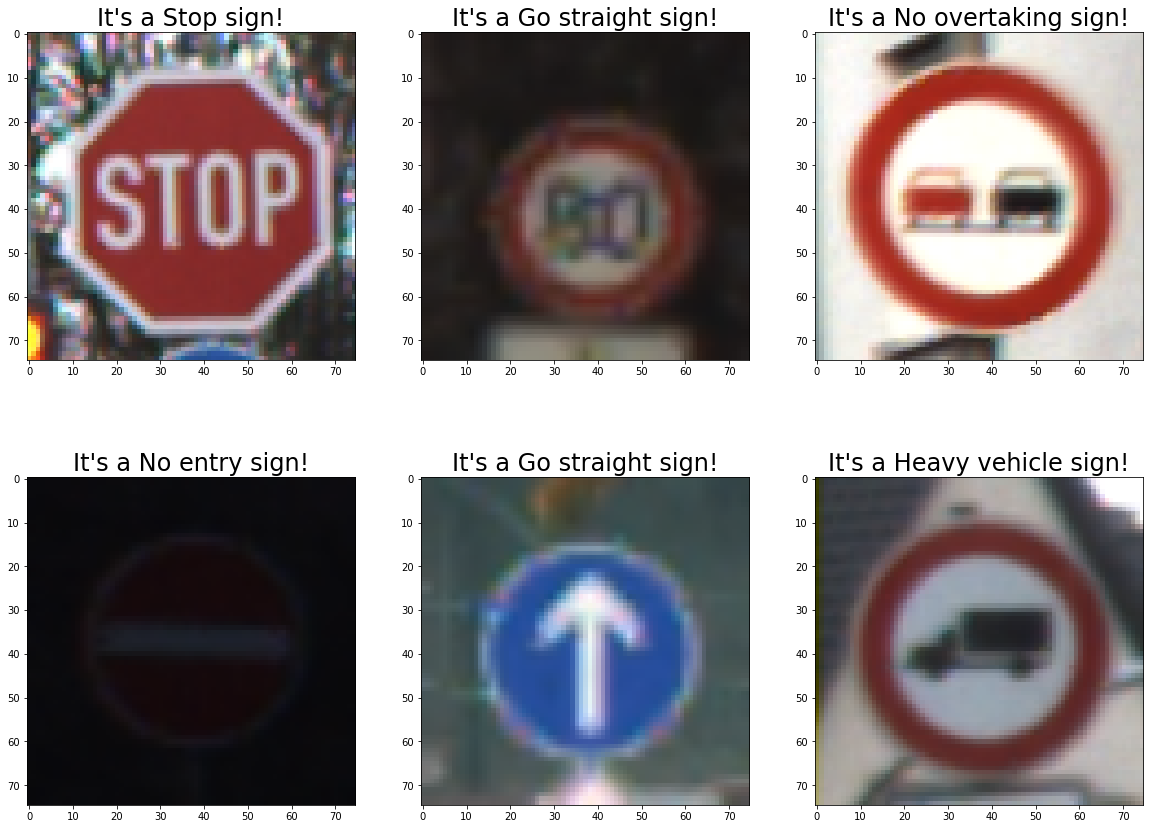

In [42]:
# test with a random image downloaded from Google Image
# It is a stop sign, hence we expect the predict answer to be 5
import matplotlib.pyplot as plt

test_imgs, _ = cm.load_data('test')
predict = []
for img in test_imgs:
    img_clone = img.copy()
    processed = cm.preprocess_image(img_clone)
    if processed is not None:
        predict.append(processed)

if len(predict) <= 0:
    print('Failed to predict!')

predict = np.array(predict)
prediction = model.predict(predict)
cols = 5
rows = math.ceil(len(predict) / cols)
sign_types = target_names
answers = [np.argmax(p) for p in prediction]
_, axes = plt.subplots(rows, cols, figsize=(20, 15))
for index, answer in enumerate(answers):
    row = int(index // cols)
    col = int(index % cols)
    sign_name = sign_types[answer]
    sign_img = test_imgs[index]
    axes[row][col].imshow(sign_img)
    axes[row][col].set_title('It\'s a %s sign!' % sign_name, size=16)
plt.show()
